# **Gaussian process implementation on "datasets.xlsx"**

## **Forward problem for prediction**

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from scipy.optimize import minimize
from datetime import datetime
from matplotlib import rcParams
import joblib
from SALib.analyze import sobol
from SALib.sample import saltelli
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF, Matern

from gpr_modelling.forward.config import MODEL_DIR, PROCESSED_DATA_DIR

%matplotlib inline

### Load models (after training)

In [2]:
# First load all models
gpr_models = {}
#for filename in os.listdir("models"):
for filename in os.listdir(MODEL_DIR):
    if filename.endswith(".pkl"):
        feat_name = filename.replace("gpr_model_", "").replace(".pkl", "")
        #model_path = os.path.join("gpr_models", filename)
        model_path = os.path.join(MODEL_DIR, filename)
        loaded_data = joblib.load(model_path)
        gpr_models[feat_name] = loaded_data['model']

# Then create a new ordered dictionary
ordered_models = {}
for i in range(3):  # For alpha/beta_0 through _2
    ordered_models[f'alpha_{i}'] = gpr_models[f'alpha_{i}']
    ordered_models[f'beta_{i}'] = gpr_models[f'beta_{i}']

gpr_models = ordered_models

### Load data

In [3]:
def load_and_split_data(path, q_dim=4, y_dim=6, shuffle=True, random_state=42):
    """
    Load data from an EXCEL file and split it into features and target variables.
    Args:
        path (str): Path to the EXCEL file.
        q_dim (int): Number of feature columns.
        y_dim (int): Number of target columns.
        shuffle (bool): Whether to shuffle the data.
        random_state (int): Random state for reproducibility.
    Returns:
        q_data (pd.DataFrame): Feature data.
        y_data (pd.DataFrame): Target data.
    """

    df = pd.read_excel(path, index_col=0)

    if df.shape[1] != q_dim + y_dim:
        raise ValueError(f"Expected {q_dim + y_dim} columns, but got {df.shape[1]}")

    if shuffle:
        df = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    q_data = df.iloc[:, :q_dim].copy()
    y_data = df.iloc[:, q_dim:].copy()

    return q_data, y_data

# Usage example
# path = 'data.csv' 
# q_dim = 4  
# y_dim = 6  
# q_data, y_data = load_and_split_data(csv_path, q_dim=q_dim, y_dim=y_dim)

### Data Split

In [4]:
def split_data(q_data, y_data, test_size=0.1, random_state=42):
    """
    Splits the data into training and testing sets.
    Args:
        q_data (pd.DataFrame): Feature data.
        y_data (pd.DataFrame): Target data.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random state for reproducibility.
    Returns:
        X_train (np.ndarray): Training feature data.
        X_test (np.ndarray): Testing feature data.
        y_train (np.ndarray): Training target data.
        y_test (np.ndarray): Testing target data.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        q_data.values, y_data.values, test_size=test_size, random_state=random_state, shuffle=True   # changed manually (default = True)
    )
    return X_train, X_test, y_train, y_test

### Normalization of output features

The normalization of the input space can be ignored, as we know for a fact that every value will fall under the $[0,1.5]^4$ range. For the output features, ${\alpha_0, \beta_0, \alpha_1, \beta_1, \alpha_2, \beta_2}$, the normalization must be done separately because, as mentioned in the paper, "... we find that the range of these six output features can be very different, specifically the ranges of $\alpha_{0}$, $\alpha_{1}$ and $\alpha_{2}$ are in hundreds and the ranges of $\beta_0$, $\beta_1$ and $\beta_2$ are
from 1 to 3."

\begin{equation}
    \begin{cases}
        (\alpha_0,\beta_0) \equiv (\alpha_{vol}, \beta_{vol})\\
        (\alpha_1,\beta_1) \equiv (\alpha_{max}, \beta_{max})\\
        (\alpha_2,\beta_2) \equiv (\alpha_{min}, \beta_{min})
    \end{cases}\
\end{equation}

In [5]:
def normalize_data(X_train, X_test, y_train, y_test, save_dir="scalers"):
    """
    Normalize the data using StandardScaler and save the scalers.
    Args:
        X_train (np.ndarray): Training feature data.
        X_test (np.ndarray): Testing feature data.
        y_train (np.ndarray): Training target data.
        y_test (np.ndarray): Testing target data.
        save_dir (str): Directory to save the scalers.
    Returns:
        X_train_scaled (np.ndarray): Scaled training feature data.
        X_test_scaled (np.ndarray): Scaled testing feature data.
        y_train_scaled (np.ndarray): Scaled training target data.
        y_test_scaled (np.ndarray): Scaled testing target data.
        q_scaler (StandardScaler): Scaler for feature data.
        y_scaler (StandardScaler): Scaler for target data.
    """
    os.makedirs(save_dir, exist_ok=True)

    q_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = q_scaler.fit_transform(X_train)
    X_test_scaled = q_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    scaler_metadata = {
        'fitted_on': f"{X_train.shape[0]} training samples",
        'timestamp': datetime.now().isoformat()
    }
    
    joblib.dump(
        {'scaler': q_scaler, 'metadata': scaler_metadata},
        os.path.join(save_dir, "q_scaler.pkl")
    )
    joblib.dump(
        {'scaler': y_scaler, 'metadata': scaler_metadata},
        os.path.join(save_dir, "y_scaler.pkl")
    )

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, q_scaler, y_scaler

In [6]:
#def extract_exp_data(q_norm, y_norm):
 #   """Extracts last row for experimental input/output (normalized)."""
  #  q_data_exp = q_norm.values[-1].reshape(1, -1)
   # y_data_exp = y_norm.values[-1].reshape(1, -1)
    #return q_data_exp, y_data_exp

### GP implementation (sklearn)

In [7]:
def train_gp_models(X_train, y_train, y_cols, save_dir="gpr_models", kernel=None):
    
    os.makedirs(save_dir, exist_ok=True)
    if kernel is None:
        #kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=0.1)
        kernel = Matern(length_scale=1.0, nu=2.5)
    
    gpr_models = {}

    for i, col in enumerate(y_cols):
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
        gpr.fit(X_train, y_train[:, i])

        model_info = {
            'model': gpr,
            'training_stats': {
                'X_mean': X_train.mean(axis=0),
                'X_std': X_train.std(axis=0),
                'y_mean': y_train[:, i].mean(),
                'y_std': y_train[:, i].std(),
            },
            'timestamp': datetime.now().isoformat()
        }
        gpr_models[col] = gpr
        joblib.dump(model_info, os.path.join(save_dir, f"gpr_model_{col}.pkl"))

    return gpr_models


### GP predictions (sklearn model)

In [8]:
def predict_with_gp(gpr_models, X_test, y_test, y_true, y_cols, y_scaler,
                    return_std=False, return_metrics=False, inverse_transform=False, verbose=True, save_dir="results"):
    """
    Predicts using trained GPR models with optional inverse scaling and metrics.
    Returns always: gpr_pred, std_pred, mse_dict, r2_dict (even if some are None).
    """

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Initialize predictions and optionally stds
    gpr_pred = np.zeros((X_test.shape[0], len(gpr_models)))
    std_pred = np.zeros((X_test.shape[0], len(gpr_models))) if return_std else None
    metrics = {'mse': {}, 'r2': {}} if return_metrics else None

    # Prediction loop
    for idx, feat in enumerate(y_cols):
        if verbose:
            print(f"Predicting for {feat}")
        
        model = gpr_models[feat]
        if return_std:
            preds, stds = model.predict(X_test, return_std=True)
            gpr_pred[:, idx] = preds
            std_pred[:, idx] = stds
        else:
            gpr_pred[:, idx] = model.predict(X_test)

    # Inverse transform
    if inverse_transform:
        gpr_pred = y_scaler.inverse_transform(gpr_pred)
        if return_std:
            std_pred = std_pred * y_scaler.scale_

    # Metrics calculation
    mse_dict, r2_dict = None, None
    if return_metrics:
        mse_dict, r2_dict = {}, {}
        for idx, feat in enumerate(y_cols):
            y_pred = gpr_pred[:, idx]

            if not inverse_transform:
                y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

            mse_dict[feat] = mean_squared_error(y_true[:, idx], y_pred)
            r2_dict[feat] = r2_score(y_true[:, idx], y_pred)

            if verbose:
                scale = "Original" if inverse_transform else "Normalized"
                print(f"{feat} ({scale} scale) - MSE: {mse_dict[feat]:.5f}, R²: {r2_dict[feat]:.5f}")

    # Save predictions (if y_true is available)
    if save_dir and y_true is not None:
        y_true = np.atleast_2d(y_true)
        if y_true.shape[0] != gpr_pred.shape[0]:
            y_true = y_true.T

        all_data = [y_true, gpr_pred]
        if return_std:
            all_data.append(std_pred)

        pred_df = pd.DataFrame(
            data=np.hstack(all_data),
            columns=[f"true_{col}" for col in y_cols] +
                    [f"pred_{col}" for col in y_cols] +
                    ([f"std_{col}" for col in y_cols] if return_std else [])
        )
        pred_df.to_csv(os.path.join(save_dir, "predictions.csv"), index=False)

        if return_metrics:
            metrics_df = pd.DataFrame({
                'Parameter': y_cols,
                'MSE': [mse_dict[col] for col in y_cols],
                'R²': [r2_dict[col] for col in y_cols]
            })
            metrics_df.to_csv(os.path.join(save_dir, "metrics.csv"), index=False)
            metrics_df.to_latex(os.path.join(save_dir, "metrics.tex"), float_format="%.4f", index=False)

    # Always return 4 elements, even if some are None
    return gpr_pred, std_pred, mse_dict, r2_dict


### Save figures and plots helper function

In [9]:
def save_figure_and_data(fig, plot_name, save_dir="results", formats=('pdf', 'png'), data_dict=None):
    """
    Saves figures in multiple formats and associated data.
    
    Args:
        fig (matplotlib.figure): Figure object to save
        plot_name (str): Base name for files (no extension)
        save_dir (str): Output directory
        formats (tuple): File formats ('pdf', 'png', 'svg', 'eps')
        data_dict (dict): Optional {filename: array} to save as CSV
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save figure in specified formats
    for fmt in formats:
        fig.savefig(
            os.path.join(save_dir,"figures", f"{plot_name}.{fmt}"),
            dpi=300,
            bbox_inches='tight',
            metadata={
                #'CreationDate': datetime.now().isoformat(),
                #'Author': 'Diogo Amaro',
                'Title': plot_name
            }
        )
    
    # Save associated data
    if data_dict:
        data_dir = os.path.join(save_dir, "plot_data")
        os.makedirs(data_dir, exist_ok=True)
        for filename, array in data_dict.items():
            np.savetxt(os.path.join(data_dir, f"{plot_name}_{filename}.csv"), 
                       array, delimiter=',', header=filename)

### Latex plot settings

In [10]:
def latexify_param(name):
    """
    Convert parameter names into LaTeX-friendly format with proper subscripts.
    Handles both Greek-letter parameters (alpha_0 → $\alpha_0$) 
    and q-parameters (q1 → $q_1$).
    """
    greek_map = {
        'alpha': r'\alpha',
        'beta': r'\beta',
        'gamma': r'\gamma',
        'delta': r'\delta'
    }
    
    # Handle Greek-letter parameters (alpha_0, beta_1, etc.)
    for greek, latex in greek_map.items():
        if name.startswith(greek):
            parts = name.split('_')
            if len(parts) > 1:
                return rf'${latex}_{{{parts[1]}}}$'  # $\alpha_{0}$
            return rf'${latex}$'  # fallback if no subscript
    
    # Handle q-parameters (q1, q2, etc.)
    if name.startswith('q') and name[1:].isdigit():
        return rf'$q_{{{name[1:]}}}$'  # $q_{1}$
    
    # Handle existing underscores (for other parameters)
    if '_' in name:
        base, sub = name.split('_', 1)
        return rf'${base}_{{{sub}}}$'
    
    return rf'${name}$'  # fallback for all other cases

# Enable LaTeX font style globally
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

### Plot_predictions

In [11]:
def plot_predictions(y_true, y_pred, y_cols, std_pred=None, mse=None, r2=None, title='Predictions plotted', save_name=None):
    """
    Plots true vs predicted values for multiple features using LaTeX-rendered fonts.
    """
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have same shape"
    assert y_true.shape[1] == len(y_cols), "y_cols length must match y_true columns"
    if std_pred is not None:
        assert std_pred.shape == y_pred.shape, "std_pred must match y_pred shape"
    if mse is not None or r2 is not None:
        assert all(feat in mse and feat in r2 for feat in y_cols), "mse/r2 keys must match y_cols"

    n_outputs = len(y_cols)
    rows = int(np.ceil(n_outputs / 3)) 
    cols = min(3, n_outputs)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten() if n_outputs > 1 else [axes] 

    # fig.suptitle(r'\textbf{' + title + r'}', fontsize=16, y=1.01)

    for i, feat in enumerate(y_cols):
        ax = axes[i]
        true_vals = y_true[:, i]
        pred_vals = y_pred[:, i]
        
        ax.scatter(true_vals, pred_vals, alpha=0.6, color='dodgerblue', 
                   edgecolor='white', s=60, label=r'\textit{Prediction}', zorder=3)
        

        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        margin = 0.1 * (max_val - min_val)
        ax.plot([min_val - margin, max_val + margin], 
                [min_val - margin, max_val + margin], 
                'r--', label=r'\textit{Perfect Fit}', linewidth=1, zorder=2)

        feat_latex = feat.replace("alpha", r"$\alpha").replace("beta", r"$\beta") + "$"
        ax.set_title(feat_latex, fontsize=12)
        # ax.set_title(r'\textbf{' + feat.replace('_', r'\_') + r'}', fontsize=12)
        ax.set_xlabel(r'\textbf{True Value}')
        ax.set_ylabel(r'\textbf{Predicted Value}')
        ax.grid(True, linestyle=':', alpha=0.7)
        
        if mse and r2:
            text_x = min_val + 0.7 * (max_val - min_val)
            text_y = min_val + 0.1 * (max_val - min_val)
            ax.text(text_x, text_y, 
                   r"$\mathrm{MSE}=$" + f"{mse[feat]:.3g}" + "\n" +
                   r"$R^2=$" + f"{r2[feat]:.3f}",
                   fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

        ax.legend(loc='upper left')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    if save_name:
        data_dict = {
            'y_true': y_true,
            'y_pred': y_pred,
            'stds': std_pred if std_pred is not None else np.zeros_like(y_pred)
        }
        
        save_figure_and_data(
            fig=plt.gcf(),
            plot_name=save_name,
            formats=('pdf', 'svg'),
            data_dict=data_dict
        )

    plt.tight_layout()
    plt.show()


### Visualize the relations

$$ p = \alpha_0 v_n ^ {\beta_0} \qquad \qquad p = \alpha_1 (\bar{\varepsilon}_{max})^{\beta_1}  \qquad \qquad p=\alpha_2 |\bar{\varepsilon}_{min}|^{\beta_2}$$

In [21]:
def plot_gp_predicted_relationships(gpr_pred, y_cols, y_scaler=None, N_curves=100, 
                                   pressure_range=(0.01, 8), figsize=(15, 4), save_name=None):
    """
    Plots physiological relationships between pressure and LV features using GP predictions.
    
    Args:
        gpr_pred (np.ndarray): Array of shape (n_samples, 6) containing predicted parameters 
                             [α₀, β₀, α₁, β₁, α₂, β₂].
        y_cols (list): List of 6 output feature names matching gpr_pred columns.
        y_scaler (StandardScaler): Optional scaler to inverse-transform parameters.
        N_curves (int): Number of Monte Carlo curves to plot.
        pressure_range (tuple): Pressure range (min, max) in mmHg.
        figsize (tuple): Figure dimensions.
    """

    # Input validation
    assert gpr_pred.shape[1] == 6, "gpr_pred must contain 6 columns (α₀,β₀,α₁,β₁,α₂,β₂)"
    assert len(y_cols) == 6, "y_cols must list 6 parameter names"
    
    # Inverse transform if y_scaler is passed
    if y_scaler is not None:
        params = y_scaler.inverse_transform(gpr_pred)
    else:
        params = gpr_pred.copy()
    
    # Parameter index mapping
    param_idx = {name: i for i, name in enumerate(y_cols)}
    required_params = ['alpha_0', 'beta_0', 'alpha_1', 'beta_1', 'alpha_2', 'beta_2']
    assert all(p in param_idx for p in required_params), "Missing required parameters in y_cols"
    
    # Linearly ramped pressure array
    p = np.linspace(*pressure_range, 100)  # mmHg
    
    # Figure initialization
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    # plt.suptitle(r"$\mathrm{Left\; ventricle\; pressure\; relationships\; with\; predicted\; parameters}$", y=1)
    
    # Plot configs
    plot_configs = [
        {
            'ax_idx': 0,
            'title': r"$\mathrm{\;}$",
            'xlabel': r"$\mathrm{Normalized\; volume}\ v_n$",
            'formula': r"$p = \alpha_0 v_n^{\beta_0}$",
            'alpha': params[:, param_idx['alpha_0']],
            'beta': params[:, param_idx['beta_0']],
            'color': 'royalblue'
        },
        {
            'ax_idx': 1,
            'title': r"$\mathrm{\;}$",
            'xlabel': r"$\mathrm{Strain}\ \bar{\varepsilon}_{max}$",
            'formula': r"$p = \alpha_1 (\bar{\varepsilon}_{max})^{\beta_1}$",
            'alpha': params[:, param_idx['alpha_1']],
            'beta': params[:, param_idx['beta_1']],
            'color': 'seagreen'
        },
        {
            'ax_idx': 2,
            'title': r"$\mathrm{\;}$",
            'xlabel': r"$\mathrm{Strain}\ |\bar{\varepsilon}_{min}|$",
            'formula': r"$p = \alpha_2 |\bar{\varepsilon}_{min}|^{\beta_2}$",
            'alpha': params[:, param_idx['alpha_2']],
            'beta': params[:, param_idx['beta_2']],
            'transform': np.abs,  # Absolute value for min strain
            'color': 'firebrick'
        }
    ]
    
    # Generate and plot relationships
    for config in plot_configs:
        ax = axes[config['ax_idx']]
        curves = []
        
        # MC sampling of parameter pairs
        for a, b in zip(config['alpha'][:N_curves], config['beta'][:N_curves]):
            with np.errstate(invalid='ignore'):
                x = (p / a) ** (1 / b)
            if 'transform' in config:
                x = config['transform'](x)
            curves.append(x)
        
        curves = np.array(curves)
        mean_curve = np.nanmean(curves, axis=0)
        std_curve = np.nanstd(curves, axis=0)
        
        
                        
        
        # Formatting
        ax.set_title(config['title'], pad=0)
        ax.set_xlabel(config['xlabel'], labelpad=8)
        ax.set_ylabel(r"$\mathrm{Pressure\, (mmHg)}$", labelpad=8)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='upper right', framealpha=1)
        
        # Dynamic axis limits
        valid_x = mean_curve[~np.isnan(mean_curve)]
        if len(valid_x) > 0:
            ax.set_xlim(0.9*valid_x.min(), 1.1*valid_x.max())
        
        # Save plot data
        if save_name:
        # Extract curve data for saving
            p = np.linspace(*pressure_range, 100)
            curve_data = {}
            for config in plot_configs:
                curves = []
                for a, b in zip(config['alpha'][:N_curves], config['beta'][:N_curves]):
                    x = (p / a) ** (1 / b)
                    if 'transform' in config:
                        x = config['transform'](x)
                    curves.append(x)
                curve_data[f"{config['xlabel']}_curves"] = np.array(curves)
        
        save_figure_and_data(
            fig=plt.gcf(),
            plot_name=save_name,
            formats=('pdf', 'eps'),
            data_dict={
                **curve_data,
                'pressure_range': p.reshape(-1, 1),
                'parameter_samples': gpr_pred[:N_curves]
            }
        )
    
    plt.tight_layout()
    plt.show()


### Workflow for intermediate vars

In [12]:
path = PROCESSED_DATA_DIR / "datasets.xlsx"
q_data, y_data = load_and_split_data(path)

In [14]:
y_cols = y_data.columns.tolist() 

In [15]:
X_train, X_test, y_train, y_test = split_data(q_data, y_data)

In [16]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, q_scaler, y_scaler = normalize_data(
    X_train, X_test, y_train, y_test
)
#q_exp, y_exp = extract_exp_data(q_norm, y_norm)

In [28]:
# gpr_models = train_gp_models(X_train_scaled, y_train_scaled, y_cols)

In [17]:
predictions, stds, mse, r2 = predict_with_gp(
    gpr_models=gpr_models,
    X_test=X_test_scaled, 
    y_test=y_test_scaled,
    y_true=y_test,
    y_cols=y_cols,
    y_scaler=y_scaler,
    return_std=True,
    return_metrics=True,
    inverse_transform=True, 
    verbose=True
)

Predicting for alpha_0
Predicting for beta_0
Predicting for alpha_1
Predicting for beta_1
Predicting for alpha_2
Predicting for beta_2
alpha_0 (Original scale) - MSE: 0.00224, R²: 0.99994
beta_0 (Original scale) - MSE: 0.00004, R²: 0.99837
alpha_1 (Original scale) - MSE: 26.54202, R²: 0.98672
beta_1 (Original scale) - MSE: 0.00047, R²: 0.98391
alpha_2 (Original scale) - MSE: 1.22042, R²: 0.99741
beta_2 (Original scale) - MSE: 0.00019, R²: 0.99434


FileNotFoundError: [Errno 2] No such file or directory: 'results/figures/predictions.pdf'

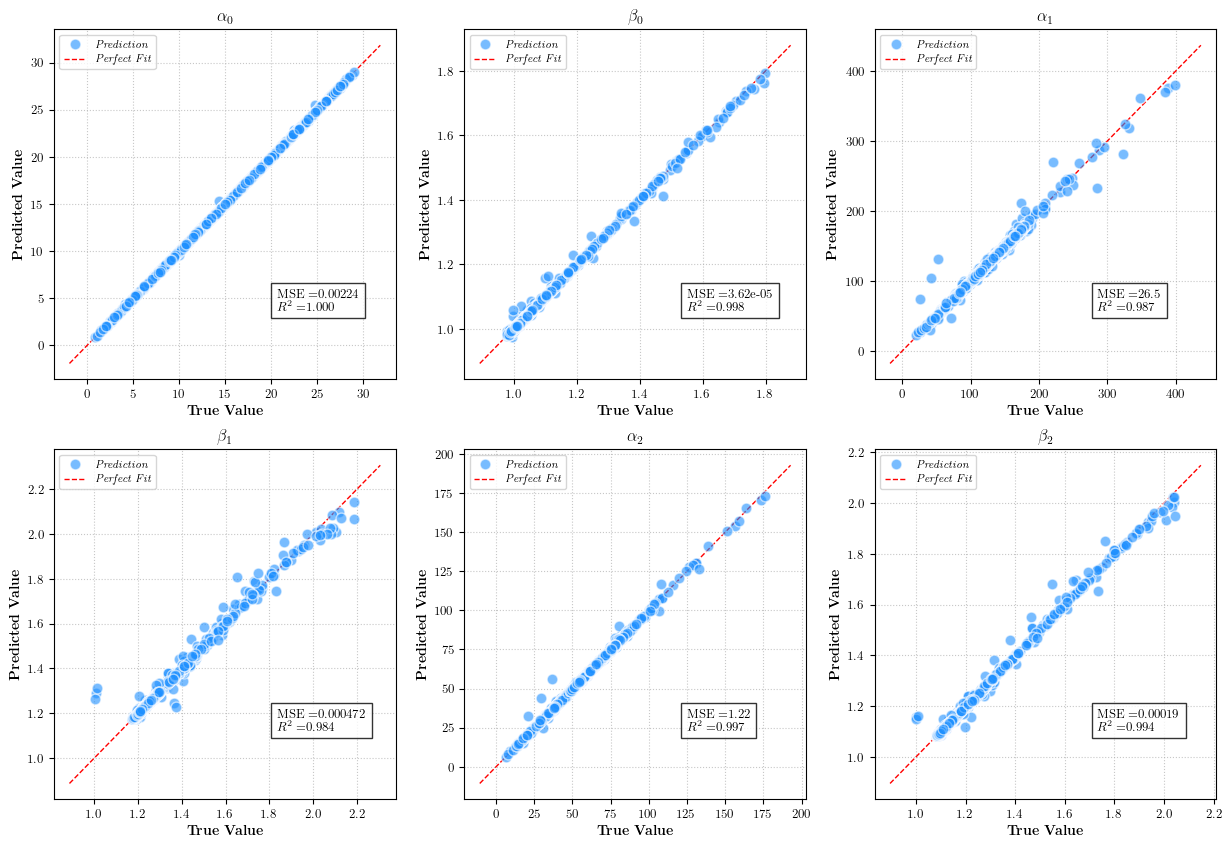

In [18]:
plot_predictions(
    y_true=y_test,  
    y_pred=predictions,
    y_cols=y_cols,
    std_pred=stds,  # optional
    mse=mse,  # optional
    r2=r2,  # optional
    title="True values vs predicted values",
    save_name="predictions",  # optional
)

/tmp/ipykernel_6387/347082809.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', framealpha=1)


UnboundLocalError: cannot access local variable 'curve_data' where it is not associated with a value

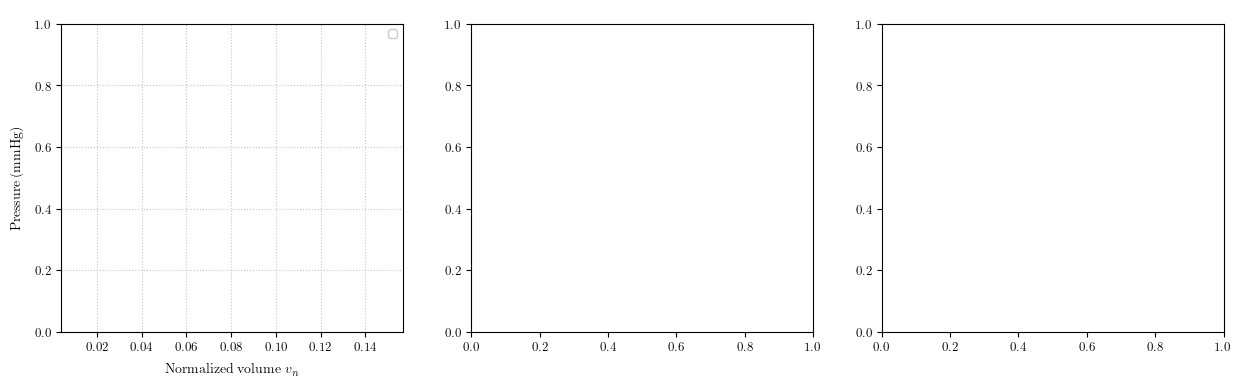

In [22]:
plot_gp_predicted_relationships(
    gpr_pred=predictions,  # (n_samples, 6)
    y_cols=y_cols,
    y_scaler=y_scaler,  # optional
    N_curves=200,  
    pressure_range=(0.1, 8),  # pressure range in mmHg
    save_name=None  # optional
)

# 1std change graph

## **Global Sensitivity Analysis**

### Writing Notes

In [ ]:
# Explain the Sobol' method and its importance in sensitivity analysis and uncertainty quantification. 
# Discuss the choice of N (1024) (?), 1st order, 2nd order and total-order indices, and the significance of the results.
# Discuss the choice of parameters (system of 8 eqs) and their bounds (0.1 and 5, its in literature somewhere).

### SA Function + JSON Encoder

In [28]:
class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types with improved numerical handling"""
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.float32, np.float64, np.float16)):
            return float(obj)
        if isinstance(obj, (np.int32, np.int64, np.int16)):
            return int(obj)
        return super().default(obj)

In [ ]:
def evaluate_model(params):
        predictions = np.zeros((params.shape[0], len(gpr_models)))
        std_devs = np.zeros_like(predictions)
        
        for i, (feat, model) in enumerate(gpr_models.items()):
            pred, std = model.predict(params, return_std=True)
            predictions[:, i] = pred.ravel()
            std_devs[:, i] = std.ravel()
            
        return y_scaler.inverse_transform(predictions)

In [30]:
def sensitivity_analysis_gp(gpr_models, q_scaler, y_scaler, sample_size=1024):
    """
    Robust Sobol sensitivity analysis with validation checks.
    
    Args:
        gpr_models: Dict of trained GP models {output_name: model}
        q_scaler: Fitted StandardScaler for inputs
        y_scaler: Fitted StandardScaler for outputs
        sample_size: Base sample count (N) for Saltelli sampling
        
    Returns:
        Dict containing Sobol indices and validation metrics
    """
    # 1. Problem definition with bounds checking
    problem = {
        'num_vars': 4,
        'names': ['q1', 'q2', 'q3', 'q4'],
        'bounds': [[0.1, 5]]*4 
    }
    
    # 2. Generate samples with sample size validation
    if sample_size > 2048:
        print("Warning: Large sample size may cause memory issues")
    param_values = saltelli.sample(problem, sample_size)
    
    # 3. Input scaling with bounds verification
    norm_pm = q_scaler.transform(param_values)
    
    # 4. Model evaluation
    Y = evaluate_model(norm_pm)
    
    # 5. Robust Sobol analysis with validation
    sobol_indices = {'results': {}, 'validation': {}}
    
    for feat in gpr_models:
        Si = sobol.analyze(problem, Y[:, list(gpr_models.keys()).index(feat)], 
                          print_to_console=False)
        
        # Validation checks
        if np.any(Si['S1'] < -0.01):
            print(f"Warning: Negative S1 for {feat}")
        if np.any(Si['ST'] < Si['S1'] - 0.01):
            print(f"Warning: ST < S1 for {feat}")
        
        # Store results
        sobol_indices['results'][feat] = {
            'S1': np.maximum(Si['S1'], 0).tolist(),
            'ST': np.maximum(Si['ST'], 0).tolist(),
            'S2': Si['S2'].tolist() if Si['S2'] is not None else None
        }
    
    return sobol_indices

### Plot Sobol Results

In [ ]:
def plot_sobol_results(sa_results, output_dir):
    """Generate all diagnostic plots"""
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. First-order and total-order indices
    for feat in sa_results['results']:
        df = pd.DataFrame({
            'First-Order': sa_results['results'][feat]['S1'],
            'Total-Order': sa_results['results'][feat]['ST']
        }, index=[f'$q_{i+1}$' for i in range(4)])
        
        ax = df.plot(kind='bar', figsize=(10, 5), width=0.8)
        ax.set_title(f"Sobol Indices for {latexify_param(feat)}", pad=20)
        ax.set_ylabel("Sensitivity Index", labelpad=10)
        ax.set_xlabel("Input Parameters", labelpad=10)
        ax.grid(axis='y', linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/sobol_{feat}.pdf", dpi=300)
        plt.close()
        
        # 2. Interaction heatmaps if available
        #if sa_results['results'][feat]['S2'] is not None:
        #    plt.figure(figsize=(6, 5))
        #    sns.heatmap(
        #        np.array(sa_results['results'][feat]['S2']),
        #        annot=True, fmt=".2f",
        #        xticklabels=[f'$q_{i+1}$' for i in range(4)],
        #        yticklabels=[f'$q_{i+1}$' for i in range(4)],
        #        cmap="vlag", center=0,
        #        square=True, cbar_kws={'label': 'Interaction Strength'}
        #    )
        #    plt.title(f"Second-Order Interactions\n{latexify_param(feat)}", pad=15)
        #    plt.tight_layout()
        #    plt.savefig(f"{output_dir}/interactions_{feat}.pdf", dpi=300)
        #    plt.close()


### Main

In [32]:
def run_sensitivity_analysis(gpr_models, q_scaler, y_scaler, output_dir, sample_size=1024):
    """Complete pipeline with error handling"""
    try:
        # Run analysis
        results = sensitivity_analysis_gp(
            gpr_models=gpr_models,
            q_scaler=q_scaler,
            y_scaler=y_scaler,
            sample_size=sample_size
        )
        
        # Save results
        with open(f"{output_dir}/sobol_results.json", "w") as f:
            json.dump(results, f, indent=4, cls=NumpyEncoder)
            
        # Generate plots
        plot_sobol_results(results, output_dir)
        
        return results
        
    except Exception as e:
        print(f"Sensitivity analysis failed: {str(e)}")
        return None

In [33]:
# Usage Example
results = run_sensitivity_analysis(
    gpr_models=gpr_models,
    q_scaler=q_scaler,
    y_scaler=y_scaler,
    output_dir="results/sensitivity_analysis",
    sample_size=1024
)


/tmp/ipykernel_3742/3755465732.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, sample_size)
/home/amaro/thesis_code/venv-thesis_env/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


## **Local Sensitivity Analysis**

### Univariate SA (non-inline labels)

### Univariate SA (inline labels)

In [ ]:
from adjustText import adjust_text

def univariate_sa(
    gpr_models, q_scaler, y_scaler,
    bounds, num_points, output_dir="local_sa"
):
    os.makedirs(output_dir, exist_ok=True)
    param_names = [f"q{i+1}" for i in range(4)]
    output_names = list(gpr_models.keys())

    for i in range(4):
        q_vals = np.linspace(bounds[i][0], bounds[i][1], num_points)
        all_params = np.ones((num_points, 4)) 
        all_params[:, i] = q_vals  

        # Scale inputs
        scaled_params = q_scaler.transform(all_params)

        # Predict outputs
        preds = evaluate_model(scaled_params) 

        # Plot each output
        plt.figure(figsize=(12, 6))
        texts=[]
        for j in range(preds.shape[1]):
            plt.plot(q_vals, preds[:, j], label=f"${latexify_param(output_names[j])}$")

            x_text = q_vals[-1]
            y_text = preds[-1, j]
            texts.append(plt.text(
                x_text,
                y_text,
                f"${latexify_param(output_names[j])}$",
                fontsize=10,
                color=plt.gca().lines[-1].get_color()
            ))

        adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='gray'))

        plt.xlabel(f"${latexify_param(param_names[i])}$")
        plt.ylabel("Output")
        # plt.yscale("log")
        plt.title(f"Univariate Sensitivity Sweep: ${latexify_param(param_names[i])}$")
        plt.grid(True, linestyle="--", alpha=0.6)
        # plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/vary_{param_names[i]}.pdf", dpi=300)
        plt.close()


### Usage

In [67]:
univariate_sa(
    gpr_models=gpr_models,
    q_scaler=q_scaler,
    y_scaler=y_scaler,
    bounds=[[0.1, 5]] * 4,
    num_points=200,
    output_dir="local_sa"
)


## **Sensitivity Analysis Validation**

### Kernel Density Analysis

In [ ]:
def kde_analysis(q_scaler, y_scaler, input_bounds, save_dir, num_samples=1000):
    """
    Enhanced KDE analysis with sensitivity validation features.
    
    Args:
        q_scaler: Fitted StandardScaler for inputs
        y_scaler: Fitted StandardScaler for outputs  
        input_bounds: Dict of parameter bounds {'q1': [min,max], ...}
        save_dir: Directory to save plots
        num_samples: Number of points per parameter sweep
    """
    os.makedirs(save_dir, exist_ok=True)
    input_params = list(input_bounds.keys())


    for vary_param in input_params:
        # Create parameter sweep
        X_fixed = np.ones((num_samples, len(input_params)))
        vary_idx = input_params.index(vary_param)
        varied_values = np.linspace(*input_bounds[vary_param], num_samples)
        X_fixed[:, vary_idx] = varied_values
        
        # Scale and predict
        X_scaled = q_scaler.transform(X_fixed)
        preds = np.zeros((num_samples, len(y_cols)))
        
        for i, feat in enumerate(y_cols):
            preds[:, i]= gpr_models[feat].predict(X_scaled, return_std=False)
        
        preds = y_scaler.inverse_transform(preds)
        
        # Identify alpha and beta parameters
        alpha_indices = [i for i, name in enumerate(y_cols) if 'alpha' in name]
        beta_indices = [i for i, name in enumerate(y_cols) if 'beta' in name]

        # Plotting
        for group, indices in [('alpha', alpha_indices), ('beta', beta_indices)]:
            plt.figure(figsize=(10, 6))
            
            for i in indices:
                # KDE plot
                sns.kdeplot(preds[:, i], fill=True, alpha=0.3, 
                            label=f"{latexify_param(y_cols[i])}")
                
            
            plt.title(f"Effect of {latexify_param(vary_param)} on ${group}$ parameters")
            plt.xlabel(f"{latexify_param(vary_param)} value")
            plt.ylabel("Output density")
            plt.legend(title="Parameters:", bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, linestyle=':', alpha=0.5)
            plt.tight_layout()
            plt.savefig(f"{save_dir}/kde_{vary_param}_{group}.pdf", bbox_inches='tight', dpi=300)
            plt.close()

In [ ]:
# Example usage

input_bounds = {
    'q1': (0.1, 5),
    'q2': (0.1, 5),
    'q3': (0.1, 5),
    'q4': (0.1, 5)
}

kde_analysis(
    q_scaler=q_scaler,
    y_scaler=y_scaler,
    input_bounds=input_bounds,
    save_dir="results/kde_analysis",
    num_samples=10000
)


### Convergence Testing

In [ ]:
import time

def plot_sobol_convergence(gpr_models, problem, q_scaler, y_scaler, 
                          sample_sizes=None, output_dir="results/convergence"):
    """
    Test and plot convergence of Sobol indices across sample sizes.
    
    Args:
        gpr_models: Dictionary of trained GP models {output_name: model}
        problem: SALib problem dictionary
        q_scaler: Fitted input scaler
        y_scaler: Fitted output scaler
        sample_sizes: List of sample sizes to test (default: [64, 128, 256, 512, 1024])
        output_dir: Directory to save plots
    """
    os.makedirs(output_dir, exist_ok=True)
    sample_sizes = sample_sizes or [64, 128, 256, 512, 1024]
    
    # Initialize results storage
    convergence_data = {
        feat: {
            'S1': np.zeros((len(sample_sizes), problem['num_vars'])),
            'ST': np.zeros((len(sample_sizes), problem['num_vars'])),
            'elapsed_times': []
        } 
        for feat in gpr_models
    }

    # Run convergence tests
    for i, N in enumerate(sample_sizes):
        print(f"Testing N={N}...")
        start_time = time.time()
        
        param_values = saltelli.sample(problem, N)
        Y = evaluate_model(q_scaler.transform(param_values))
        
        for feat in gpr_models:
            Si = sobol.analyze(
                problem, 
                Y[:, list(gpr_models.keys()).index(feat)],
                print_to_console=False
            )
            convergence_data[feat]['S1'][i] = np.maximum(Si['S1'], 0)
            convergence_data[feat]['ST'][i] = np.maximum(Si['ST'], 0)
        
        elapsed = time.time() - start_time
        for feat in gpr_models:
            convergence_data[feat]['elapsed_times'].append(elapsed/len(gpr_models))

    # Generate convergence plots
    param_labels = [f"${latexify_param(name)}$" for name in problem['names']]
    
    for feat in gpr_models:
        plt.figure(figsize=(12, 6))
        
        # S1 convergence
        plt.subplot(1, 2, 1)
        for j in range(problem['num_vars']):
            plt.plot(sample_sizes, convergence_data[feat]['S1'][:, j], 
                     'o-', label=param_labels[j])
        
        plt.xscale('log')
        plt.xlabel('Sample Size (log scale)')
        plt.ylabel('First-Order Index (S1)')
        plt.title(f'S1 Convergence: {latexify_param(feat)}')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # ST convergence
        plt.subplot(1, 2, 2)
        for j in range(problem['num_vars']):
            plt.plot(sample_sizes, convergence_data[feat]['ST'][:, j],
                     's--', label=param_labels[j])
        
        plt.xscale('log')
        plt.xlabel('Sample Size (log scale)')
        plt.ylabel('Total-Order Index (ST)')
        plt.title(f'ST Convergence: {latexify_param(feat)}')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/convergence_{feat}.pdf", dpi=300)
        plt.close()
    
    # Save numerical results
    with open(f"{output_dir}/convergence_data.json", 'w') as f:
        json.dump({
            feat: {
                'S1': convergence_data[feat]['S1'].tolist(),
                'ST': convergence_data[feat]['ST'].tolist(),
                'elapsed_times': convergence_data[feat]['elapsed_times'],
                'sample_sizes': sample_sizes
            }
            for feat in gpr_models
        }, f, indent=4, cls=NumpyEncoder)
    
    return convergence_data

In [ ]:
problem = {
        'num_vars': 4,
        'names': ['q1', 'q2', 'q3', 'q4'],
        'bounds': [[0.1, 5]]*4  # Verified bounds
    }

plot_sobol_convergence(
    gpr_models=gpr_models,
    problem=problem,
    q_scaler=q_scaler,
    y_scaler=y_scaler,
    sample_sizes=[512, 1024,2048],
    output_dir="results/sa_convergence"
)

## **Inverse problem for parameter inference**

### Approach 1: Point estimate with MSE minimize

### Approach 2: Point estimation with differential evolution

#### Callback + DE -> 1 run

In [ ]:
from scipy.optimize import differential_evolution

y_obs = y_test[-1]  # add noise

# ----- Define the loss function -----
def loss_function(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = np.array(q).reshape(1, -1)  # Ensure 2D shape
    q_scaled = q_scaler.transform(q)

    # Predict using the GPR models (output is still scaled)
    y_pred_scaled = np.array([
        gpr_models[feature].predict(q_scaled)[0]
        for feature in gpr_models.keys()
    ]).reshape(1, -1)

    # Inverse-transform the prediction to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

    # Compute loss: Mean Squared Error
    return np.mean((y_pred - y_obs) ** 2)

# Loss tracking
loss_trace = []

def callback_func(xk, convergence):
    """Callback to track loss during optimization."""
    loss = loss_function(xk, gpr_models, y_obs, q_scaler, y_scaler)
    loss_trace.append(loss)


# ----- Define bounds for differential evolution -----
# For each q_i ∈ [lb, ub]
lb = 0.1
ub = 5.0
bounds = [(lb, ub)] * 4  # 4 parameters

# ----- Run optimization -----
result = differential_evolution(
    loss_function,
    bounds=bounds,
    args=(gpr_models, y_obs, q_scaler, y_scaler),  # y_obs = y_test[-1]
    strategy="best1bin",
    mutation=(0.5, 1.5),
    callback=callback_func,
    maxiter=1000,
    popsize=15,
    tol=0.01,
    disp=False,
    polish=True
)

# ----- Extract and report results -----
point_estimate_q = result.x
final_loss = result.fun

print("Best-fit parameters (point estimate):", point_estimate_q)
print("Final MSE loss:", final_loss)
print("True values:", X_test[-1])
print("Absolute error:", np.abs(point_estimate_q - X_test[-1]))


Best-fit parameters (point estimate): [4.50062448 3.58824823 1.83015187 3.51693551]
Final MSE loss: 1.9558090699170095e-10
True values: [4.5003191  3.58852013 3.89245368 3.50792196]
Absolute error: [3.05383285e-04 2.71902165e-04 2.06230181e+00 9.01354201e-03]


#### Callback + DE -> 50 runs

In [ ]:
import random
from scipy.optimize import differential_evolution

# ----- Define the loss function -----
def loss_function(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = np.array(q).reshape(1, -1)  # Ensure 2D shape
    q_scaled = q_scaler.transform(q)

    # Predict using the GPR models (output is still scaled)
    y_pred_scaled = np.array([
        gpr_models[feature].predict(q_scaled)[0]
        for feature in gpr_models.keys()
    ]).reshape(1, -1)

    # Inverse-transform the prediction to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

    # Compute loss: Mean Squared Error
    return np.mean((y_pred - y_obs) ** 2)

# -------- Loss tracking --------
loss_trace = []

def callback_func(xk, convergence):
    """Callback to track loss during optimization."""
    loss = loss_function(xk, gpr_models, y_obs, q_scaler, y_scaler)
    loss_trace.append(loss)

# ----- Define bounds for differential evolution -----
num_runs = 5
all_estimates = []
all_losses = []
all_errors = []

true_q = X_test[-1]
y_clean = y_test[-1]
noise_std = 0.05

loss_iter = random.randint(0, num_runs-1)  # Randomly select a run for the loss tracking

# Loop over 50 DE runs
for run in range(num_runs):
    if run == loss_iter:
        noise = np.random.normal(0, noise_std, size=y_clean.shape)
        y_obs = y_clean + noise

        # DE optimization
        result = differential_evolution(
            loss_function,
            bounds=[(0.1, 5.0)] * 4,
            args=(gpr_models, y_obs, q_scaler, y_scaler),
            strategy="best1bin",
            mutation=(0.5, 1.5),
            maxiter=1000,
            popsize=15,
            callback=callback_func,
            tol=0.01,
            disp=False,
            polish=True
        )

        q_est = result.x
        loss = result.fun
        abs_error = np.abs(q_est - true_q)

        print(q_est)

        all_estimates.append(q_est)
        all_losses.append(loss)
        all_errors.append(abs_error)

    else:
        noise = np.random.normal(0, noise_std, size=y_clean.shape)
        y_obs = y_clean + noise

        # DE optimization
        result = differential_evolution(
            loss_function,
            bounds=[(0.1, 5.0)] * 4,
            args=(gpr_models, y_obs, q_scaler, y_scaler),
            strategy="best1bin",
            mutation=(0.5, 1.5),
            maxiter=1000,
            popsize=15,
            tol=0.01,
            disp=False,
            polish=True
        )

        q_est = result.x
        loss = result.fun
        abs_error = np.abs(q_est - true_q)


        all_estimates.append(q_est)
        all_losses.append(loss)
        all_errors.append(abs_error)

all_estimates = np.array(all_estimates)  # shape: (50, 4)
all_errors = np.array(all_errors)        # shape: (50, 4)

# Get the best estimate *per* q_i
best_qs = []
best_indices = []

for i in range(4):
    best_idx = np.argmin(all_errors[:, i])
    best_q = all_estimates[best_idx, i]
    best_qs.append(best_q)
    best_indices.append(best_idx)

best_qs = np.array(best_qs)

# Report
print("Best per-component estimates:")
for i in range(4):
    print(f"q{i+1}: estimate = {best_qs[i]:.4f} (from run {best_indices[i]}) | true = {true_q[i]:.4f} | abs error = {abs(best_qs[i] - true_q[i]):.4f}")

print(f"Final inference results: {best_qs}")


[4.50270299 3.57669036 2.65185854 3.62984018]
[4.2318729  3.73527241 3.30216695 0.30679322]
[4.41919868 3.65195367 3.34517434 1.46312695]
[4.49469222 3.59702887 2.57025478 3.32451242]
[4.3617486  3.68821669 3.1922208  0.904497  ]
Best per-component estimates:
q1: estimate = 4.5027 (from run 0) | true = 4.5003 | abs error = 0.0024
q2: estimate = 3.5970 (from run 3) | true = 3.5885 | abs error = 0.0085
q3: estimate = 3.3452 (from run 2) | true = 3.8925 | abs error = 0.5473
q4: estimate = 3.6298 (from run 0) | true = 3.5079 | abs error = 0.1219


#### Trace Plot

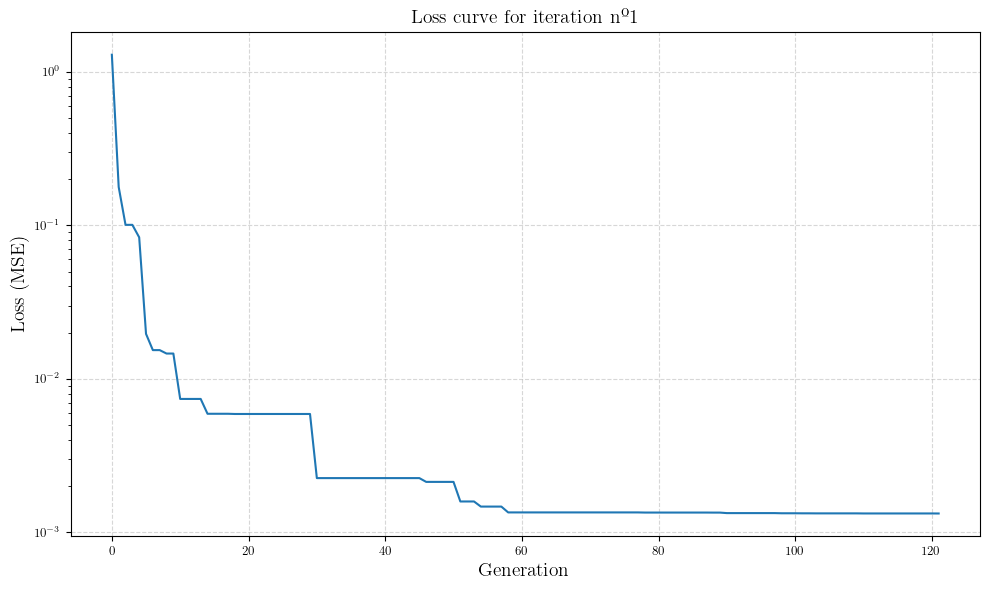

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(loss_trace, linestyle='-')
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)
plt.yscale("log")
plt.title(f"Loss curve for iteration nº{loss_iter}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### KDE plots for each q after 50 runs

In [1]:
param_names = ['q1', 'q2', 'q3', 'q4']

plt.figure(figsize=(12, 6))
for i in range(len(param_names)):
    sns.kdeplot(all_estimates[:, i], fill=True, label=param_names[i], linewidth=2)

plt.xlabel("Estimated Value")
plt.ylabel("Density")
# plt.yscale("log")
plt.title("KDE of estimated parameters from 50 DE runs")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig("kde_q_estimates.pdf", dpi=300)
plt.show()


NameError: name 'plt' is not defined

### Approach 3: MCMC with emcee library (distribution over possible inputs)

#### Inference

In [1]:
import numpy as np
import emcee

def log_likelihood(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = q.reshape(1, -1)
    
    # Scale q to match GP input space
    q_scaled = q_scaler.transform(q)

    # Predict scaled y values from each GP
    means_scaled = []
    stds = []
    for feature in gpr_models.keys():
        mean_scaled, std = gpr_models[feature].predict(q_scaled, return_std=True)
        means_scaled.append(mean_scaled[0])
        stds.append(std[0])

    means_scaled = np.array(means_scaled).reshape(1, -1)

    # Inverse transform predictions back to original y scale
    if y_scaler is not None:
        means = y_scaler.inverse_transform(means_scaled).flatten()
    else:
        means = means_scaled.flatten()

    # Compute likelihood using predicted means and assumed std dev
    stds = np.array(stds)
    if y_scaler is not None:
        stds = stds * y_scaler.scale_
    stds += 1e-6  # for numerical stability

    residuals = y_obs - means
    log_likelihood_val = -0.5 * np.sum((residuals / stds)**2 + np.log(2 * np.pi * stds**2))

    return log_likelihood_val


def log_prior(q, lb, ub):
    if np.all(lb <= q) and np.all(q <= ub):
        return 0.0
    return -np.inf


def log_posterior(q, gpr_models, y_obs, lb, ub, q_scaler, y_scaler):
    lp = log_prior(q, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(q, gpr_models, y_obs, q_scaler, y_scaler)


# ---- Setup ----
ndim = 4  # number of latent parameters
nwalkers = 32 #32
nsteps = 5000 #10000

# Bounds (arrays)
lb = np.array([0.1] * ndim)
ub = np.array([5.0] * ndim)

# Initial guess for walkers
x0 = np.random.uniform(low=lb, high=ub, size=(nwalkers, ndim))

# Observation vector (6D)
y_obs = y_test[-1]

# ---- Run MCMC ----
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior,
    args=(gpr_models, y_obs, lb, ub, q_scaler, y_scaler)
)

sampler.run_mcmc(x0, nsteps, progress=True)

# ---- Analyze Results ----
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
inferred_params_mean = np.mean(samples, axis=0)
inferred_params_std = np.std(samples, axis=0)

print("Inferred Parameters (Mean):", inferred_params_mean)
print("Uncertainty (Std Dev):", inferred_params_std)
print("True Values:", X_test[-1])
print("Error:", np.abs(inferred_params_mean - X_test[-1]))


NameError: name 'y_test' is not defined

#### Plot

q1: True = 4.500, Mean = 4.294, 95% CI = [3.077, 5.511] Inside 95% CI
q2: True = 3.589, Mean = 3.619, 95% CI = [2.416, 4.821] Inside 95% CI
q3: True = 3.892, Mean = 2.575, 95% CI = [0.159, 4.991] Inside 95% CI
q4: True = 3.508, Mean = 3.503, 95% CI = [1.465, 5.540] Inside 95% CI


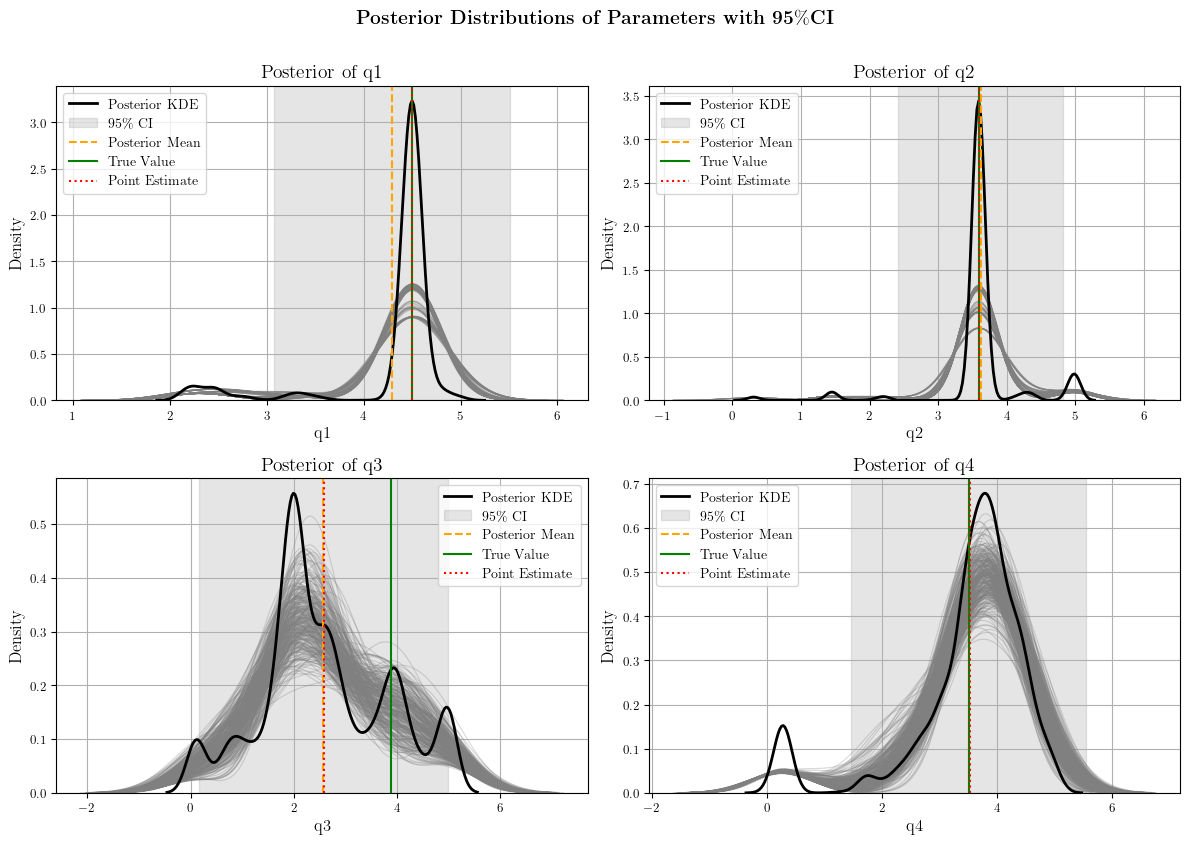

In [114]:
param_labels = [f"q{i+1}" for i in range(ndim)]
true_params = X_test[-1]

# Retrieve individual chains (shape: nwalkers, nsteps, ndim)
chains = sampler.get_chain(discard=2000, thin=10)

nwalkers, nsteps, ndim = chains.shape

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(ndim):
    # Flattened samples for full KDE
    param_samples = samples[:, i]
    mean = inferred_params_mean[i]
    std = inferred_params_std[i]
    ci_lower = mean - 1.96 * std
    ci_upper = mean + 1.96 * std
    true_val = true_params[i]
    ax = axes[i]

    # Plot KDEs for each walker (faint)
    for w in range(nwalkers):
        sns.kdeplot(chains[w, :, i], ax=ax, color='gray', linewidth=0.8, alpha=0.3)

    # Main KDE of all samples
    sns.kdeplot(param_samples, ax=ax, color="black", linewidth=2, label="Posterior KDE")

    # Fill 95% CI
    ax.axvspan(ci_lower, ci_upper, color='gray', alpha=0.2, label=r"$95\%$ CI")

    # Vertical lines for mean and true value
    ax.axvline(mean, color='orange', linestyle='--', label=r"Posterior Mean")
    ax.axvline(true_val, color='green', linestyle='-', label=r"True Value")

    # Point estimate
    ax.axvline(point_estimate_q[i], color='red', linestyle=':', label=r"Point Estimate")

    # Labels
    ax.set_title(f"Posterior of {param_labels[i]}", fontsize=14)
    ax.set_xlabel(f"{param_labels[i]}", fontsize=12)
    ax.set_ylabel(r"Density", fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=10)

    # Print information
    if true_val < ci_lower or true_val > ci_upper:
        status = "Outside 95% CI"
    else:
        status = "Inside 95% CI"
    print(f"{param_labels[i]}: True = {true_val:.3f}, Mean = {mean:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}] {status}")

plt.tight_layout()
plt.suptitle(r"\textbf{Posterior Distributions of Parameters with }$\mathbf{95\%}$\textbf{CI}", fontsize=14, y=1.05)
plt.show()
